In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize

from gwbench import injections

In [2]:
def p_m1(m1, alpha, beta, m_min, m_t, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1 and beta != -1:
        N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1))/(alpha+1)
                  + m_t**(alpha-beta)*(m_max**(beta+1) - m_t**(beta+1))/(beta+1))
    else:
        if alpha == -1 and beta != -1:
            N1 = 1 / (np.log(m_t/m_min) + m_t**(alpha-beta) *
                      (m_max**(beta+1) - m_t**(beta+1))/(beta+1))
        elif alpha != -1 and beta == -1:
            N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1)) /
                      (alpha+1) + m_t**(alpha-beta)*np.log(m_max/m_t))
        else:
            N1 = 1/(np.log(m_t/m_min) + m_t**(alpha-beta)*np.log(m_max/m_t))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_t), (m1 >= m_t)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, lambda m1: N1*m_t**(alpha-beta)*m1**beta, 0])

def p_q(q, gamma, q_min):
    '''
    BBH merger mass ratio PDF.
    '''
    Nq = (gamma+1)/(1-q_min**(gamma+1))
    return Nq * q**gamma


def p_z(z, z_min, z_max):
    '''
    BBH merger redshift PDF.
    '''
    Nz = 1/integrate.quad(lambda x: (1+x)**(2.6) /
                          (1 + ((1+x)/3.2)**(6.2)), z_min, z_max)[0]
    return Nz * (1+z)**(2.6)/(1 + ((1+z)/3.2)**(6.2))


def p_s(s, alpha_s, beta_s):
    '''
    BH spin PDF.
    '''
    N_s = 1 / integrate.quad(lambda ss: ss**(alpha_s-1)
                             * (1-ss)**(beta_s-1), 0, 1)[0]
    return N_s * s**(alpha_s-1)*(1-s)**(beta_s-1)


def R_mrg(z, R02, z_min, z_max):
    '''
    Volumetric merger rate density.
    '''
    return R02 * p_z(z, z_min, z_max)/p_z(0.2, z_min, z_max)

In [3]:
N_events = 5000

seed = 329
# Initialize pseudo-random number generator:
np.random.seed(seed)

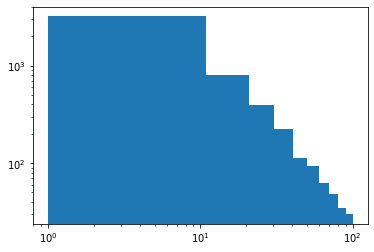

In [33]:
# Sample primary masses:
alpha=-1.
beta=-2.
m_min = 1
m_t = 20.
m_max = 100

m1 = np.linspace(m_min, m_max, 10**5)

pdf_m1 = p_m1(m1, alpha, beta, m_min, m_t, m_max)
cdf_m1 = integrate.cumulative_trapezoid(pdf_m1, m1, initial=0)
inv_cdf_m1 = interpolate.interp1d(cdf_m1 / cdf_m1[-1], m1)
m1_events = inv_cdf_m1(np.random.rand(N_events))

plt.hist(m1_events)
plt.loglog()
plt.show()

In [34]:
# Sample secondary masses:
m2_events = np.zeros(N_events)
gamma = 0.
for i in range(0, N_events):
    q_min = m_min/m1_events[i]
    q = np.linspace(q_min, 1, 10**2)
    pdf_q = p_q(q, gamma, q_min)
    cdf_q = integrate.cumulative_trapezoid(pdf_q, q, initial=0)
    inv_cdf_q = interpolate.interp1d(cdf_q / cdf_q[-1], q)
    m2_events[i] = m1_events[i] * inv_cdf_q(np.random.rand())

In [35]:
alpha_s = 1.
beta_s = 2. 
# Sample primary spins:
s1 = np.linspace(0, 1, 10**3)
pdf_s1 = p_s(s1, alpha_s, beta_s)
cdf_s1 = integrate.cumulative_trapezoid(pdf_s1, s1, initial=0)
inv_cdf_s1 = interpolate.interp1d(cdf_s1 / cdf_s1[-1], s1)
s1_events = inv_cdf_s1(np.random.rand(N_events))
# Sample secondary spins:
s2 = np.linspace(0, 1, 10**3)
pdf_s2 = p_s(s2, alpha_s, beta_s)
cdf_s2 = integrate.cumulative_trapezoid(pdf_s2, s2, initial=0)
inv_cdf_s2 = interpolate.interp1d(cdf_s2 / cdf_s2[-1], s2)
s2_events = inv_cdf_s2(np.random.rand(N_events))

z_min = 0.1
z_out = 3.0
# Sample redshifts:
z = np.linspace(z_min, z_out, 10**3)
pdf_z = p_z(z, z_min, z_out)
cdf_z = integrate.cumulative_trapezoid(pdf_z, z, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z)
z_events = inv_cdf_z(np.random.rand(N_events))
# Sample external angles:
iota_events, ra_events, dec_events, psi_events = injections.angle_sampler(
    N_events, seed)


# Infer Population Parameters

In [36]:
def fit_function(m1, alpha, beta, m_t):
    m_min = 1
    # m_t = 20
    m_max = 100
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1 and beta != -1:
        N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1))/(alpha+1)
                  + m_t**(alpha-beta)*(m_max**(beta+1) - m_t**(beta+1))/(beta+1))
    else:
        if alpha == -1 and beta != -1:
            N1 = 1 / (np.log(m_t/m_min) + m_t**(alpha-beta) *
                      (m_max**(beta+1) - m_t**(beta+1))/(beta+1))
        elif alpha != -1 and beta == -1:
            N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1)) /
                      (alpha+1) + m_t**(alpha-beta)*np.log(m_max/m_t))
        else:
            N1 = 1/(np.log(m_t/m_min) + m_t**(alpha-beta)*np.log(m_max/m_t))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_t), (m1 >= m_t)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, lambda m1: N1*m_t**(alpha-beta)*m1**beta, 0])

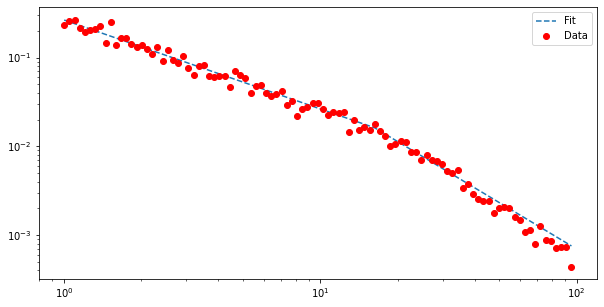

In [37]:
target_func = fit_function
bins = np.logspace(0, 2, 100)

y, X = np.histogram(m1_events, bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()

popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-0.8, -2.3, 30])

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label='Fit')

plt.plot(X, y, 'ro', label='Data')
plt.loglog()
plt.legend()
plt.show()

In [38]:
popt

array([-1.00195381, -1.73363023, 16.29746724])